# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-polarizadores-lineales" data-toc-modified-id="Determinación-de-los-parámetros-de-los-polarizadores-lineales-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los polarizadores lineales</a></div><div class="lev2 toc-item"><a href="#Cargar-la-intensidad-con-P1-y-P4" data-toc-modified-id="Cargar-la-intensidad-con-P1-y-P4-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cargar la intensidad con P1 y P4</a></div><div class="lev2 toc-item"><a href="#Fitting-data-to-sine" data-toc-modified-id="Fitting-data-to-sine-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fitting data to sine</a></div><div class="lev2 toc-item"><a href="#Calibration-parameters" data-toc-modified-id="Calibration-parameters-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Calibration parameters</a></div><div class="lev1 toc-item"><a href="#Otros-ajustes" data-toc-modified-id="Otros-ajustes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Otros ajustes</a></div><div class="lev2 toc-item"><a href="#Fitting-to-matrices---1:-sencillo" data-toc-modified-id="Fitting-to-matrices---1:-sencillo-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fitting to matrices - 1: sencillo</a></div><div class="lev2 toc-item"><a href="#Ajuste-global:-p0,-p1,-angulo" data-toc-modified-id="Ajuste-global:-p0,-p1,-angulo-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ajuste global: p0, p1, angulo</a></div><div class="lev3 toc-item"><a href="#Verificación" data-toc-modified-id="Verificación-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Verificación</a></div><div class="lev3 toc-item"><a href="#Comparación" data-toc-modified-id="Comparación-222"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Comparación</a></div><div class="lev3 toc-item"><a href="#Conclusión" data-toc-modified-id="Conclusión-223"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Conclusión</a></div>

# Determinación de los parámetros del divisor de haz usando dos polarizadores

**Autor**: Jesús del Hoyo

**Fecha**:   2/08/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm (corriente = 314 mA).
1. Lente colimadora de Thorlabs DG10-600-B.
1. Difusor.
1. Polarizador 1 LPNIRE100-B (P1).
1. Polarizador 4 LPNIRE100-B (P2), solo en Experimento 2.

We assume that beam splitters behaves as a diattenuator retarder with $J_{xy} = J_{yx} = 0$:

\begin{equation}
J_{BS}(0)=\left[\begin{array}{cc}
A & 0  \\
0 & B e^{i\delta}
\end{array}\right]
\end{equation}

**4th experiment**:
1. Polarizador 1 LPNIRE100-B (P1).
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP (R1).
1. Divisor de haz Thorlabs CCM1-BS014/M (BS).
1. Polarizador 1 LPNIRE100-B (P2).

Variables: 
1. 2D, P1 and P2 rotation.
1. 2D, R1 and P2 rotation.

Parameters that can be extracted from fit:
1. Theta 0 of R1.
1. R parameters (moddeled as diattenuator retarder).



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt
from cmath import exp

from phyton_optics import degrees , sp, plt

from scipy import optimize, exp
from scipy.io import loadmat

from polarimeter.utils import plot_experiment_residuals_1D
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting


from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import numpy as np
import os

## Load data

In [3]:
# Go to the desired folder
#dir = 'calibration'
print(os.getcwd())
#os.chdir(dir)

# Load file, Experiment 4
filename = 'Experimento_4_2018-07-31.npz'
data = np.load(filename)
# Rename variables
angle_e4x = data['angle2x']*degrees
angle_e4y = data['angle2y']*degrees
Imax_e4 = data['intensity_max']
I_e4 = data['intensity2']
I_e4 = I_e4[0:15,0:14] # Wrongy created as a 90x90 zero's matrix


D:\Codigo UCM\polarimeter\notebooks\calibration\calibration 6


## Experiment 4: Rotating both pols

This experiment is done to measure the parameters of the diattenuator retarder. 

Fit parameters for the quarter waveplate: A = 1.02372320909; B = 1.0089316968; delta = 85.9435620726º; Th0 = 36.2485255347º;


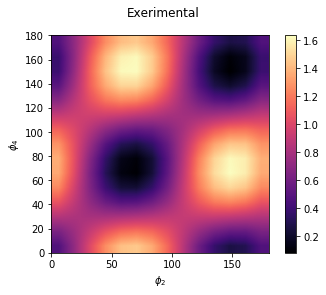

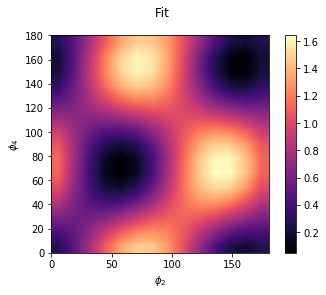

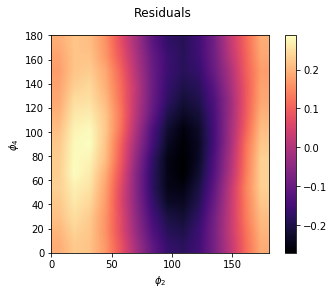

In [5]:
# Initial parameters
Jp = pj.real_polarizer(P1=0.9567, P2=0.138)
Jbs = pj.real_polarizer(P1=0.9024, P2=0.9096)
th0 = [33.98*degrees, 169.4*degrees, 116.87*degrees]
par0 = [.95, 0.95, 90*degrees, 0]
# Define calculating and distance functions
def model_func2D(par, th1, th2): 
    Jr = pj.diattenuator_retarder(delta = par[2], A = par[0], B = par[1])    
    J = [Jp, Jr, Jbs, Jp]
    th = [th1-th0[0], par[3], -th0[1], th2-th0[2]]
    I = Intensity_Rotating_Elements(J, th, Imax_e4/2)
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angle_e4x, angle_e4y, I_e4))
# Print results
print('Fit parameters for the quarter waveplate: A = {}; B = {}; delta = {}º; Th0 = {}º;'.format(
        par1[0], par1[1], (par1[2]/degrees)%180, (par1[3]/degrees)%180 ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angle_e4x, angle_e4y)
residuals = I_e4 - I_fitting
dibujar_2d_fitting(angle_e4x, angle_e4y, I_e4, title='Exerimental')
dibujar_2d_fitting(angle_e4x, angle_e4y, I_fitting, title='Fit')
dibujar_2d_fitting(angle_e4x, angle_e4y, residuals, title='Residuals')


## Fit general element

Let's try to use $J_{xy}$ and $J_{yx}$ different than 0 and complex.

[[0.96280986+0.j         0.18895268-0.11363762j]
 [0.38842943-0.25171591j 0.20142304+1.02317116j]]
Fit parameters for the quarter waveplate: Jxx = 0.962809861739; |Jxy| = 0.220491778651; Dxy = 148.976968871º;
Fit parameters for the quarter waveplate: |Jyx| = 0.462858861487; Dyx = 147.055345858º; |Jyy| = 1.04280892446; Dyy = 78.8630764041º;
Fit parameters for the quarter waveplate: Th0 = 22.7321784976º;


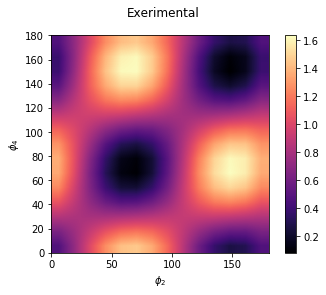

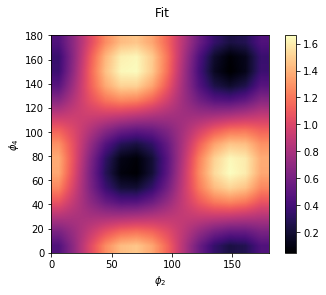

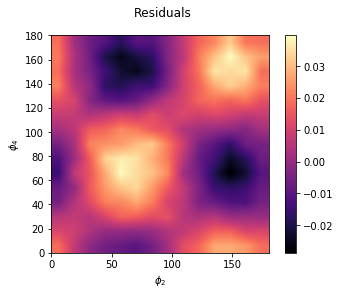

In [12]:
# Initial parameters
Jp = pj.real_polarizer(P1=0.9567, P2=0.138)
Jbs = pj.real_polarizer(P1=0.9024, P2=0.9096)
th0 = [33.98*degrees, 169.4*degrees, 116.87*degrees]
par0 = [.95, 0, 0, 0, 0, 0.95, 90*degrees, 0]
# Define calculating and distance functions
def generalJones(par):
    J = Jr = matrix(array([[par[0], par[1]*exp(1j*par[2])], [par[3]*exp(1j*par[4]), par[5]*exp(1j*par[6])] ]))  
    return J
def model_func2D(par, th1, th2): 
    Jr = generalJones(par)
    J = [Jp, Jr, Jbs, Jp]
    th = [th1-th0[0], par[7], -th0[1], th2-th0[2]]
    I = Intensity_Rotating_Elements(J, th, Imax_e4/2)
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angle_e4x, angle_e4y, I_e4))
# Print results
Jfin = generalJones(par1)
print(Jfin)
print('Fit parameters for the quarter waveplate: Jxx = {}; |Jxy| = {}; Dxy = {}º;'.format(
        par1[0], par1[1], (par1[2]/degrees)%180))
print('Fit parameters for the quarter waveplate: |Jyx| = {}; Dyx = {}º; |Jyy| = {}; Dyy = {}º;'.format(
        par1[3], (par1[4]/degrees)%180, par1[5], (par1[6]/degrees)%180))
print('Fit parameters for the quarter waveplate: Th0 = {}º;'.format(
        (par1[7]/degrees)%180 ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angle_e4x, angle_e4y)
residuals = I_e4 - I_fitting
dibujar_2d_fitting(angle_e4x, angle_e4y, I_e4, title='Exerimental')
dibujar_2d_fitting(angle_e4x, angle_e4y, I_fitting, title='Fit')
dibujar_2d_fitting(angle_e4x, angle_e4y, residuals, title='Residuals')

This component seems to be much different to the real one, but the result seems to be very good (error lower than 35 mV), the best obtained fitting this element. Just to check, I will repeat the experiment of fitting the data using ideal polarizer and ideal diattenuator retarder.

## Experiment4: Ideal polarizers and diattenuator retarder

Fit parameters for the quarter waveplate: A = 0.953098381299; B = 0.94773863785; delta = 85.6616117984º; Th0 = 36.3056476654º;


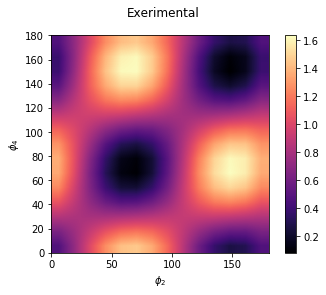

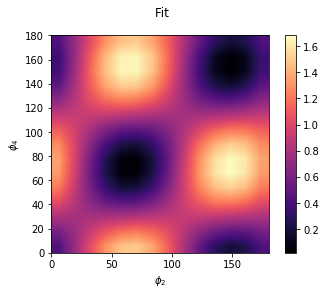

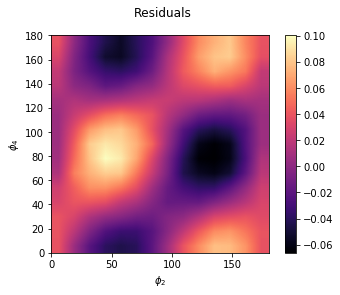

In [13]:
# Initial parameters
Jp = pj.real_polarizer(P1=1, P2=0)
Jbs = pj.real_polarizer(P1=0.9024, P2=0.9096)
th0 = [33.98*degrees, 169.4*degrees, 116.87*degrees]
par0 = [.95, 0.95, 90*degrees, 0]
# Define calculating and distance functions
def model_func2D(par, th1, th2): 
    Jr = pj.diattenuator_retarder(delta = par[2], A = par[0], B = par[1])    
    J = [Jp, Jr, Jbs, Jp]
    th = [th1-th0[0], par[3], -th0[1], th2-th0[2]]
    I = Intensity_Rotating_Elements(J, th, Imax_e4/2)
    return I
def err_func2D(par, th1, th2, y): 
    dI = model_func2D(par, th1, th2) - y 
    return dI.flatten()
# Optimize
par1, success = optimize.leastsq(err_func2D, par0, args=(angle_e4x, angle_e4y, I_e4))
# Print results
print('Fit parameters for the quarter waveplate: A = {}; B = {}; delta = {}º; Th0 = {}º;'.format(
        par1[0], par1[1], (par1[2]/degrees)%180, (par1[3]/degrees)%180 ))
#par1[3] = 45*degrees
#par1 = [1, 1, pi/2, pi/4]
I_fitting = model_func2D(par1, angle_e4x, angle_e4y)
residuals = I_e4 - I_fitting
dibujar_2d_fitting(angle_e4x, angle_e4y, I_e4, title='Exerimental')
dibujar_2d_fitting(angle_e4x, angle_e4y, I_fitting, title='Fit')
dibujar_2d_fitting(angle_e4x, angle_e4y, residuals, title='Residuals')

Mmmm, this time it doesn't work. That convinces me that I am in the right way.

## Conclusion

The quarter waveplate can`t be modeled as a diattenuator retarder. It has to be modeled as a general Jones element. The fit elements are:
1. $J_{xx} = 0.9628$.
1. $|J_{xy}| = 0.2205$, $\delta_{xy} = 149.0º$.
1. $|J_{yx}| = 0.4629$, $\delta_{yx} = 147.1º$.
1. $|J_{yy}| = 1.0428$, $\delta_{yy} = 78.9º$.
1. $\Theta_{0R} = 85.7º$.